# Integration of Post-Translational Modification Spaces in Lung Cancer Signaling Pathways

Analysis of the lim_log2_ratio_data.txt data containing ratios of methylation, phosphorylation and acytelation.


In [7]:
# install packages
install.packages("VennDiagram")
library("VennDiagram")
install.packages("Rtsne")
library("Rtsne")


also installing the dependencies ‘lambda.r’, ‘futile.options’, ‘futile.logger’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: grid
Loading required package: futile.logger
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [9]:
# loading data table
ptm_temp = read.table("data/lim_log2_ratio_data.txt", sep="\t")

# data loaded into matrix
ptm_temp[1:5,1:5]

,Channel.127..H1417,Channel.128..DMS79,Channel.129..H128,Channel.130..H209.1,Channel.131..H524
A2M ack K1162,-0.4446114,-0.4296726,-0.2524272,-0.2015250,0.2354993
AAAS p S541,-1.0587969,-1.0923710,-1.5112494,-0.8429631,-1.6890770
AACS p T659,0.2291709,-0.8743050,-0.4078308,0.2377656,-2.2098692
AAK1 p S846,NA,NA,NA,NA,NA
AAK1 p T375,NA,NA,NA,NA,NA


In [41]:
# separate the gene symbol from PTM type and modification location
genes = rownames(ptm_temp)
sp = strsplit(genes, " ")

In [42]:
#store gene information in matrix and remove on unique entries with multiple gene symbols
ll = unlist(lapply(sp, length))
ww = which(ll == 3)

In [43]:
#subset data matrix
ptm = ptm_temp[ww,]
geneinfo = do.call(rbind, sp[ww])
colnames(geneinfo) = c("genesymbol", "ptm", "ptmsite")

# show unique measurement types
print("Count of measurement types")
table(geneinfo[,2])

# gene info view
geneinfo[1:10,]

[1] "Count of measurement types"



 ack  kme    p  rme 
2903  319 8383 2161 

genesymbol,ptm,ptmsite
A2M,ack,K1162
AAAS,p,S541
AACS,p,T659
AAK1,p,S846
AAK1,p,T375
AAK1,p,T389
AAK1,p,Y28
AAMDC,rme,R69
AARS,ack,K19
AASDHPPT,ack,K151


In [23]:
#identify genes that are captured for the four PTMs
ptmP = which(geneinfo[,2] == "p")
numP = length(ptmP)
genesP = unique(geneinfo[ptmP, 1])

ptmA = which(geneinfo[,2] == "ack")
numA = length(ptmA)
genesA = unique(geneinfo[ptmA, 1])

ptmR = which(geneinfo[,2] == "rme")
numR = length(ptmR)
genesR = unique(geneinfo[ptmR, 1])

ptmK = which(geneinfo[,2] == "kme")
numK = length(ptmK)
genesK = unique(geneinfo[ptmK, 1])

In [25]:
# calculate intersections of gene sets
n12 = intersect(genesP, genesA)
n13 = intersect(genesP, genesR)
n14 = intersect(genesP, genesK)
n23 = intersect(genesA, genesR)
n24 = intersect(genesA, genesK)
n34 = intersect(genesR, genesK)

n123 = intersect(n12, genesR)
n124 = intersect(n12, genesK)
n134 = intersect(n13, genesK)
n234 = intersect(n23, genesK)

n1234 = intersect(n123, n234)

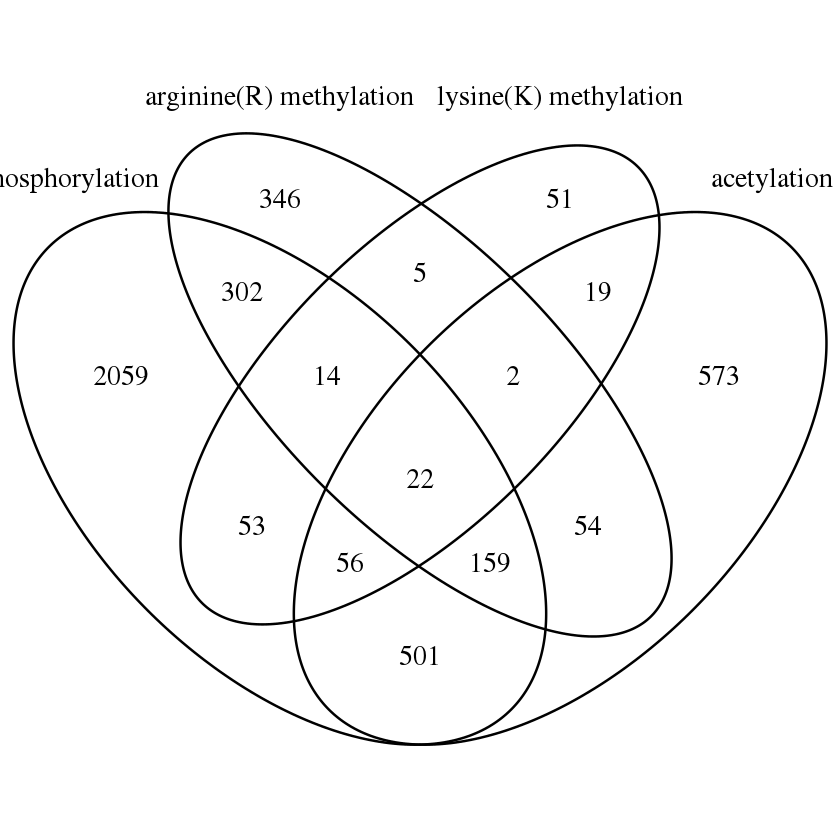

In [30]:
vp = draw.quad.venn(length(genesP), length(genesA), length(genesR), length(genesK), length(n12), length(n13), length(n14), length(n23), length(n24), length(n34), length(n123), length(n124), length(n134), length(n234), length(n1234), category=c("phosphorylation","acetylation","arginine(R) methylation", "lysine(K) methylation"),  cat.cex = 1.4, cex=1.4)


In [34]:
# calculate correlation of gene acetylation and phosphorylation for data vector pairs with at least 10 overlapping non NA values
genesAP = sort(n12)
correlations = c()

for(gene in genesAP){
    phosphorylation = grep(paste(gene, "p"), rownames(ptm))[1]
    acetylation = grep(paste(gene, "a"), rownames(ptm))[1]
    
    phosphorylation_data = ptm[phosphorylation, ]
    acetylation_data = ptm[acetylation, ]
    
    ww = which(!is.na(phosphorylation_data) & !is.na(acetylation_data))
    
    if(length(ww) >= 10){
        correlation = cor(t(phosphorylation_data), t(acetylation_data), use="pairwise.complete.obs")
        correlations = c(correlations, correlation)
    }
}
correlations = na.omit(correlations)


Warning message in cor(t(phosphorylation_data), t(acetylation_data), use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(t(phosphorylation_data), t(acetylation_data), use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(t(phosphorylation_data), t(acetylation_data), use = "pairwise.complete.obs"):
“the standard deviation is zero”

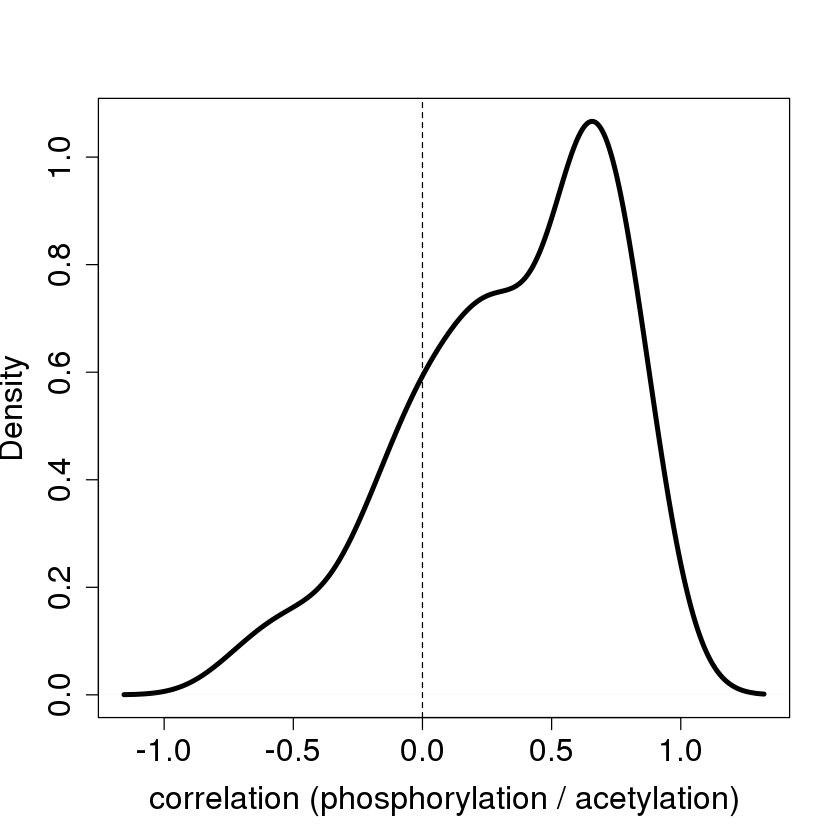

In [36]:
# plot results
plot(density(correlations), lwd=4, xlab="correlation (phosphorylation / acetylation)", cex.lab=1.6, cex.axis=1.6, main="")
abline(v=0, lty=2)

## The correlations between phosphorylation and acetylation are positive due to normalization effects in the protein data

The following code applies a median polish on the data to remove sample effects. This breaks spurrious correlations in the current data.

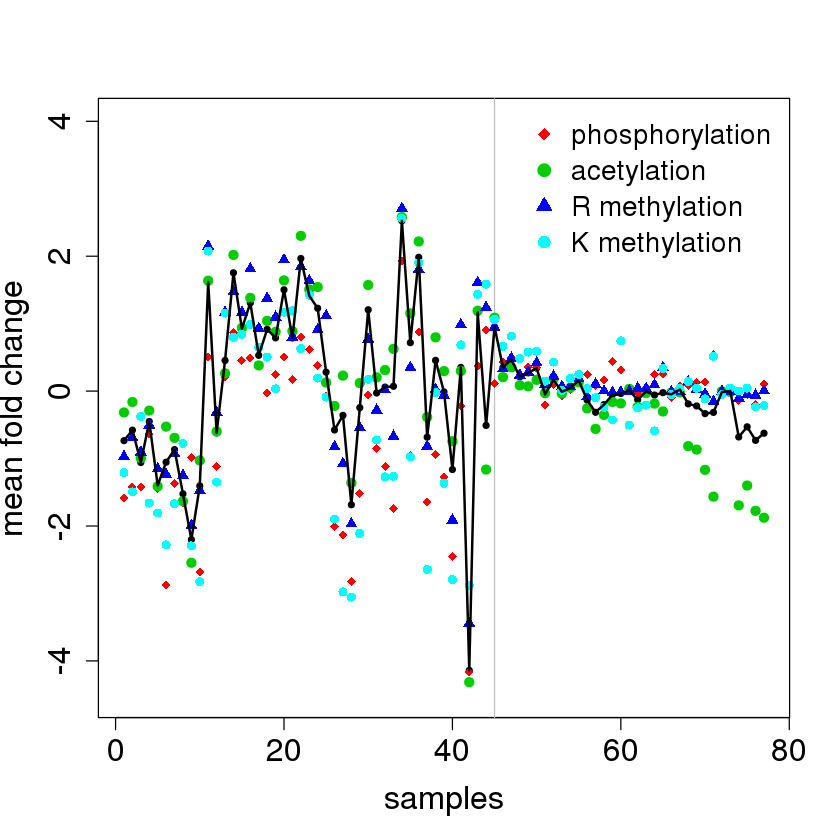

In [38]:
# Show current sample bias
plot(colMeans(ptm, na.rm=T), pch=20, cex.lab=1.6, cex.axis=1.6, xlab="samples", ylab="mean fold change", ylim=c(-4.5,4))
abline(v=45, col="grey")
points(colMeans(ptm[ptmA,], na.rm=T), pch=18, col=2)
points(colMeans(ptm[ptmP,], na.rm=T), pch=19, col=3)
points(colMeans(ptm[ptmR,], na.rm=T), pch=17, col=4)
points(colMeans(ptm[ptmK,], na.rm=T), pch=16, col=5)
lines(colMeans(ptm, na.rm=T), lty=1, lwd=2)
legend("topright", legend=c("phosphorylation", "acetylation", "R methylation", "K methylation"), col=2:5, pch=c(18, 19, 17,16), cex=1.4, bty = "n")

In [40]:
# apply median polish on the data and plot again
polishedPTM = medpolish(ptm, na.rm = T)$residuals

1: 230070.1
2: 219489.2
Final: 218638


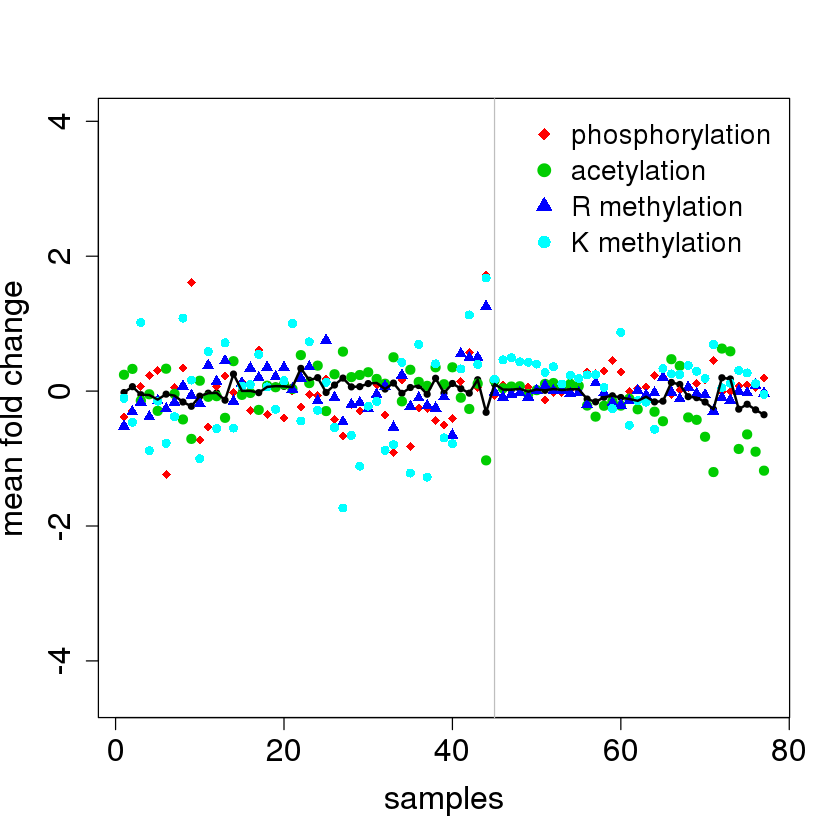

In [55]:
plot(colMeans(polishedPTM, na.rm=T), pch=20, cex.lab=1.6, cex.axis=1.6, xlab="samples", ylab="mean fold change", ylim=c(-4.5,4))
abline(v=45, col="grey")
points(colMeans(polishedPTM[ptmA,], na.rm=T), pch=18, col=2)
points(colMeans(polishedPTM[ptmP,], na.rm=T), pch=19, col=3)
points(colMeans(polishedPTM[ptmR,], na.rm=T), pch=17, col=4)
points(colMeans(polishedPTM[ptmK,], na.rm=T), pch=16, col=5)
lines(colMeans(polishedPTM, na.rm=T), lty=1, lwd=2)
legend("topright", legend=c("phosphorylation", "acetylation", "R methylation", "K methylation"), col=2:5, pch=c(18, 19, 17,16), cex=1.4, bty = "n")

## Correlation phosphorylation - acetylation

In [62]:
correlationsPolished = c()

for(gene in genesAP){
    phosphorylation = grep(paste(gene, "p"), rownames(polishedPTM))[1]
    acetylation = grep(paste(gene, "a"), rownames(polishedPTM))[1]
    
    phosphorylation_data = polishedPTM[phosphorylation, -c(1:45)]
    acetylation_data = polishedPTM[acetylation, -c(1:45)]
    
    ww = which(!is.na(phosphorylation_data) & !is.na(acetylation_data))
    
    if(length(ww) >= 5){
        correlation = cor(phosphorylation_data[ww], acetylation_data[ww])
        correlationsPolished = c(correlationsPolished, correlation)
    }
}
correlationsPolished = na.omit(correlationsPolished)

phosphorylation = grep(" p ", rownames(polishedPTM))
acetylation = grep(" ack ", rownames(polishedPTM))

phosphorylation_data = polishedPTM[phosphorylation, -c(1:45)]
acetylation_data = polishedPTM[acetylation, -c(1:45)]
cc = cor(t(phosphorylation_data), t(acetylation_data), use="pairwise.complete")

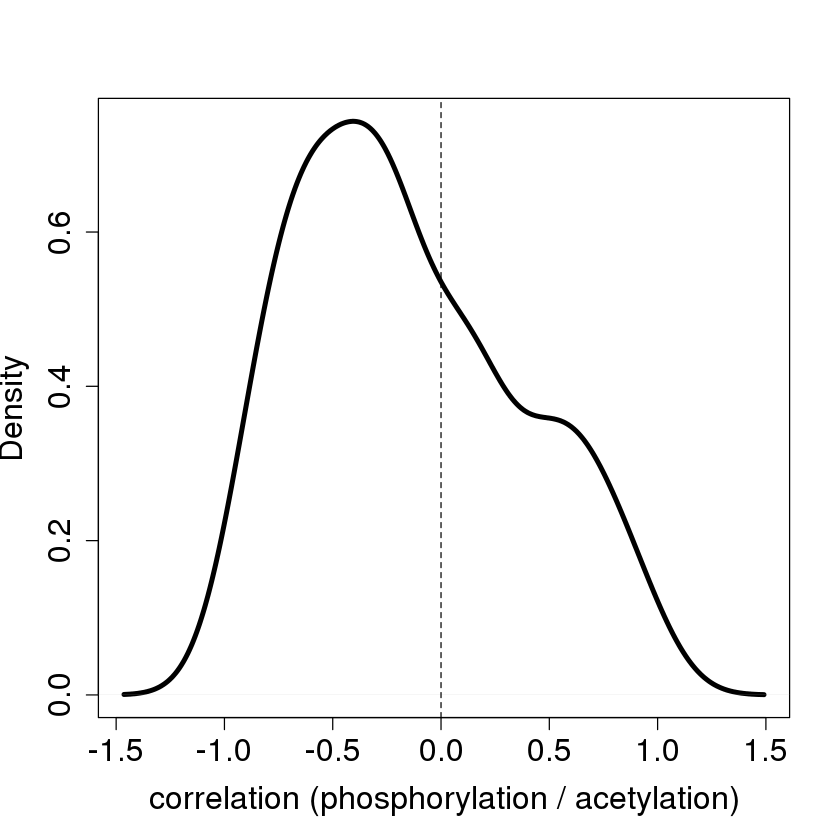

In [63]:
plot(density(correlationsPolished), lwd=4, xlab="correlation (phosphorylation / acetylation)", cex.lab=1.6, cex.axis=1.6, main="")
abline(v=0, lty=2)

## Phosphorylation - argenine methylation

In [64]:
genesAR = sort(n13)
# recalculate correlations on polished fold change matrix
correlationsPolished = c()

for(gene in genesAR){
    phosphorylation = grep(paste(gene, "p"), rownames(polishedPTM))[1]
    acetylation = grep(paste(gene, "r"), rownames(polishedPTM))[1]
    
    phosphorylation_data = polishedPTM[phosphorylation, ]
    acetylation_data = polishedPTM[acetylation, ]
    
    ww = which(!is.na(phosphorylation_data) & !is.na(acetylation_data))
    
    if(length(ww) >= 5){
        correlation = cor(phosphorylation_data[ww], acetylation_data[ww])
        correlationsPolished = c(correlationsPolished, correlation)
    }
}
correlationsPolished = na.omit(correlationsPolished)

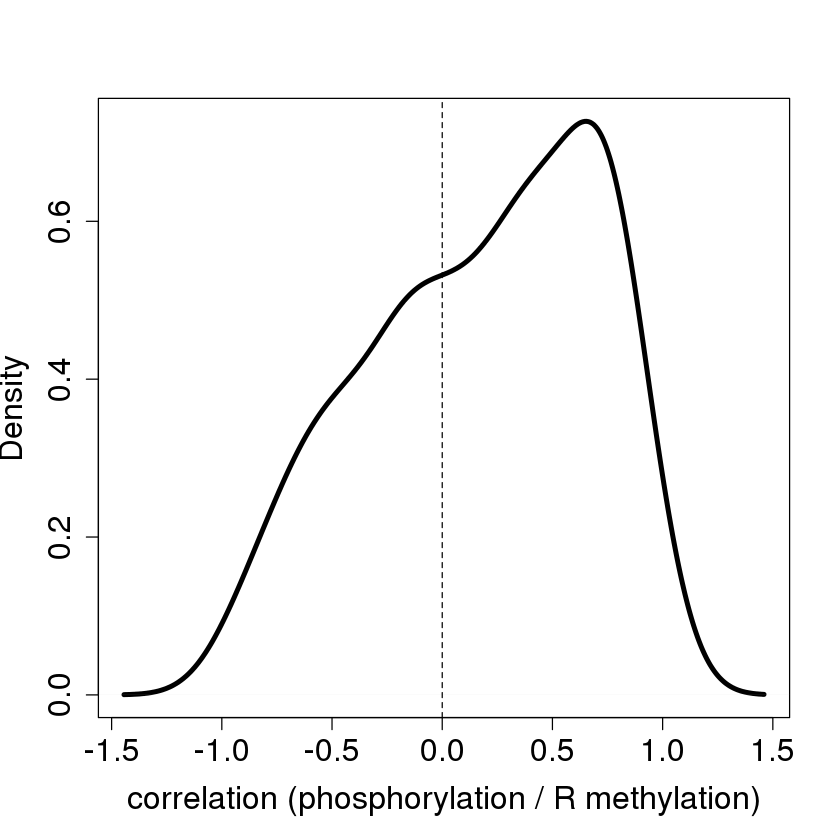

In [65]:
plot(density(correlationsPolished), lwd=4, xlab="correlation (phosphorylation / R methylation)", cex.lab=1.6, cex.axis=1.6, main="")
abline(v=0, lty=2)

## Phosphorylation - lysine methylation

In [66]:
genesAK = sort(n14)
# recalculate correlations on polished fold change matrix
correlationsPolished = c()

for(gene in genesAK){
    phosphorylation = grep(paste(gene, "p"), rownames(polishedPTM))[1]
    acetylation = grep(paste(gene, "r"), rownames(polishedPTM))[1]
    
    phosphorylation_data = polishedPTM[phosphorylation, ]
    acetylation_data = polishedPTM[acetylation, ]
    
    ww = which(!is.na(phosphorylation_data) & !is.na(acetylation_data))
    
    if(length(ww) >= 5){
        correlation = cor(phosphorylation_data[ww], acetylation_data[ww])
        correlationsPolished = c(correlationsPolished, correlation)
    }
}
correlationsPolished = na.omit(correlationsPolished)


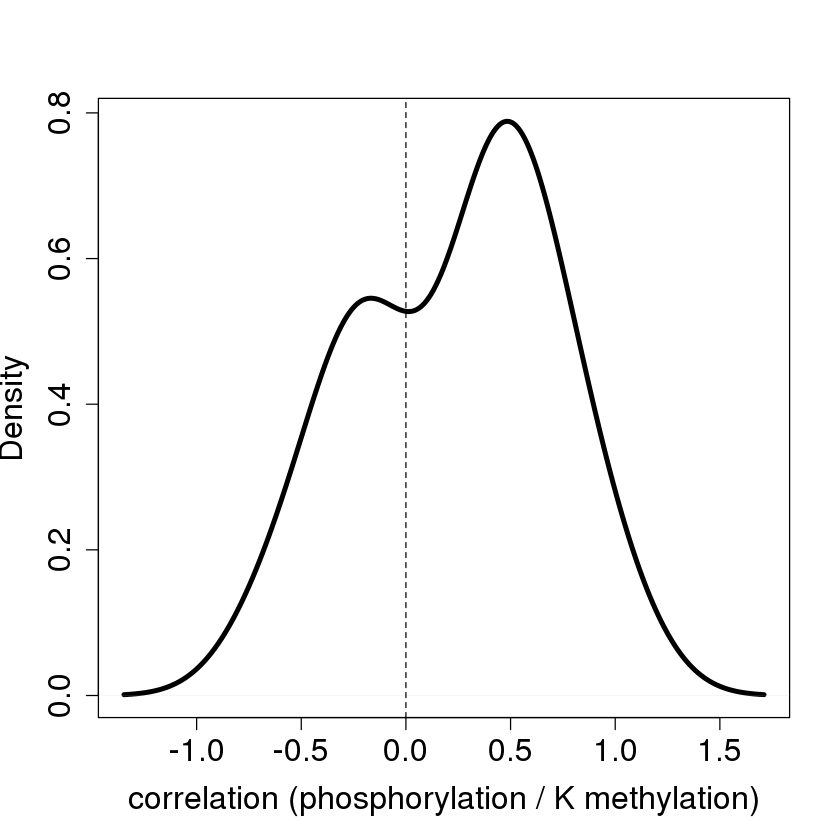

In [67]:
plot(density(correlationsPolished), lwd=4, xlab="correlation (phosphorylation / K methylation)", cex.lab=1.6, cex.axis=1.6, main="")
abline(v=0, lty=2)

## Correlation acetylation - lysine methylation

In [68]:
# recalculate correlations on polished fold change matrix
genesAK = sort(n24)

correlationsPolished = c()

for(gene in genesAK){
    phosphorylation = grep(paste(gene, "p"), rownames(polishedPTM))[1]
    acetylation = grep(paste(gene, "r"), rownames(polishedPTM))[1]
    
    phosphorylation_data = polishedPTM[phosphorylation, ]
    acetylation_data = polishedPTM[acetylation, ]
    
    ww = which(!is.na(phosphorylation_data) & !is.na(acetylation_data))
    
    if(length(ww) >= 5){
        correlation = cor(phosphorylation_data[ww], acetylation_data[ww])
        correlationsPolished = c(correlationsPolished, correlation)
    }
}
correlationsPolished = na.omit(correlationsPolished)


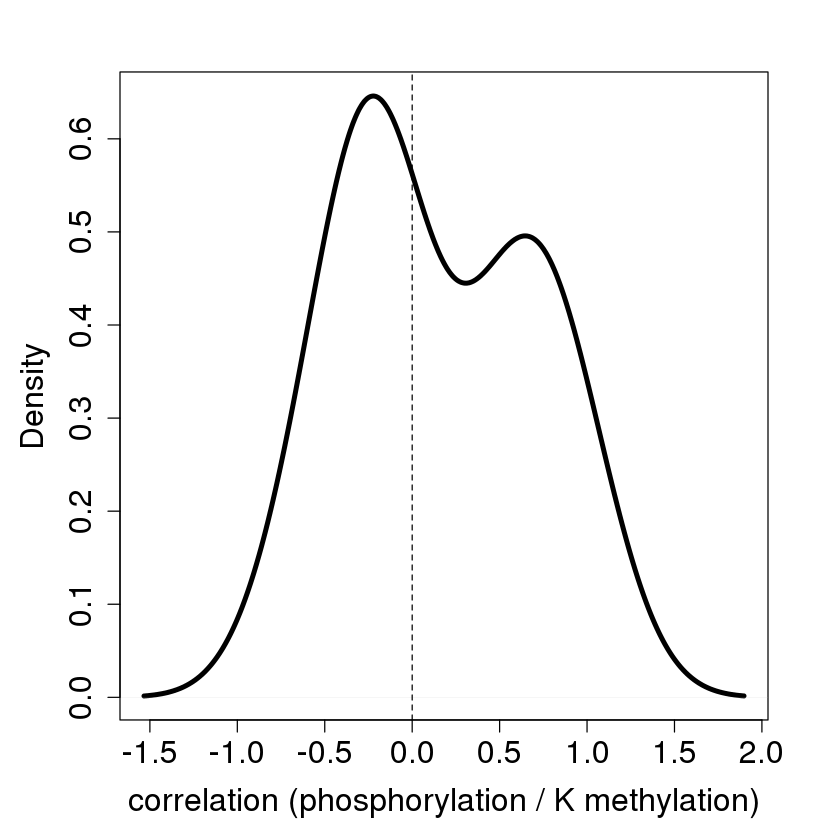

In [69]:
par(mar=c(5,5,3,3))
plot(density(correlationsPolished), lwd=4, xlab="correlation (phosphorylation / K methylation)", cex.lab=1.6, cex.axis=1.6, main="")
abline(v=0, lty=2)

## Correlation acetylation - argenine methylation

In [52]:
# recalculate correlations on polished fold change matrix
genesAK = sort(n23)
correlationsPolished = c()

for(gene in genesAK){
    phosphorylation = grep(paste(gene, "a"), rownames(polishedPTM))[1]
    acetylation = grep(paste(gene, "r"), rownames(polishedPTM))[1]
    
    phosphorylation_data = polishedPTM[phosphorylation, ]
    acetylation_data = polishedPTM[acetylation, ]
    
    ww = which(!is.na(phosphorylation_data) & !is.na(acetylation_data))
    
    if(length(ww) >= 5){
        correlation = cor(phosphorylation_data[ww], acetylation_data[ww])
        correlationsPolished = c(correlationsPolished, correlation)
    }
}
correlationsPolished = na.omit(correlationsPolished)


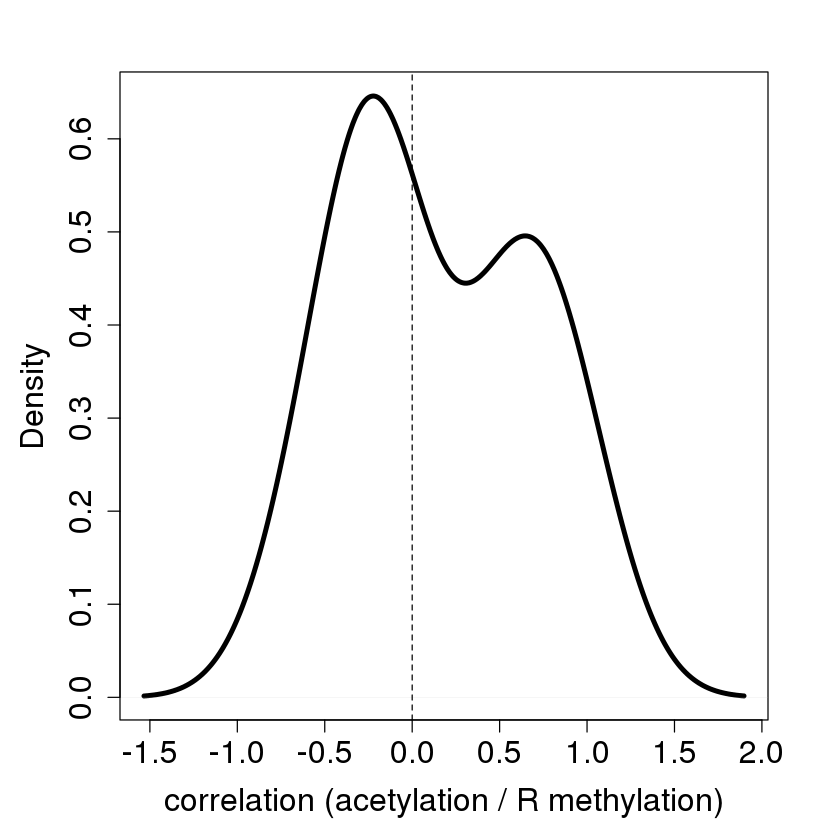

In [72]:
par(mar=c(5,5,3,3))
plot(density(correlationsPolished), lwd=4, xlab="correlation (acetylation / R methylation)", cex.lab=1.6, cex.axis=1.6, main="")
abline(v=0, lty=2)

## t-SNE

In [26]:
dat = ptm_temp
dat[is.na(dat)] = 0
ts = Rtsne(dat, dims=2, perplexity=20, check_duplicates = F)

[1] 13798     2

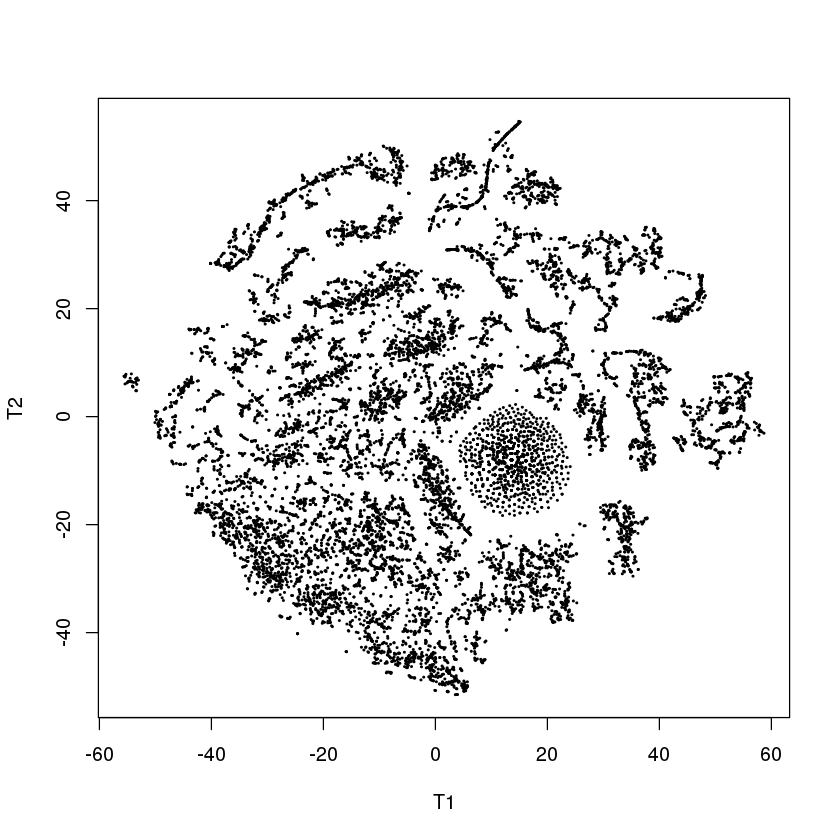

In [27]:
dim(ts$Y)
plot(ts$Y, pch=20, cex=0.3, xlab="T1", ylab="T2")

In [35]:
g1 = grep(" p ", rownames(dat))
g2 = grep(" ack ", rownames(dat))
g3 = grep(" kme ", rownames(dat))
g4 = grep(" rme ", rownames(dat))


In [36]:
rr = rep(1, nrow(dat))
rr[g1] = 2
rr[g2] = 3
rr[g3] = 4
rr[g4] = 5

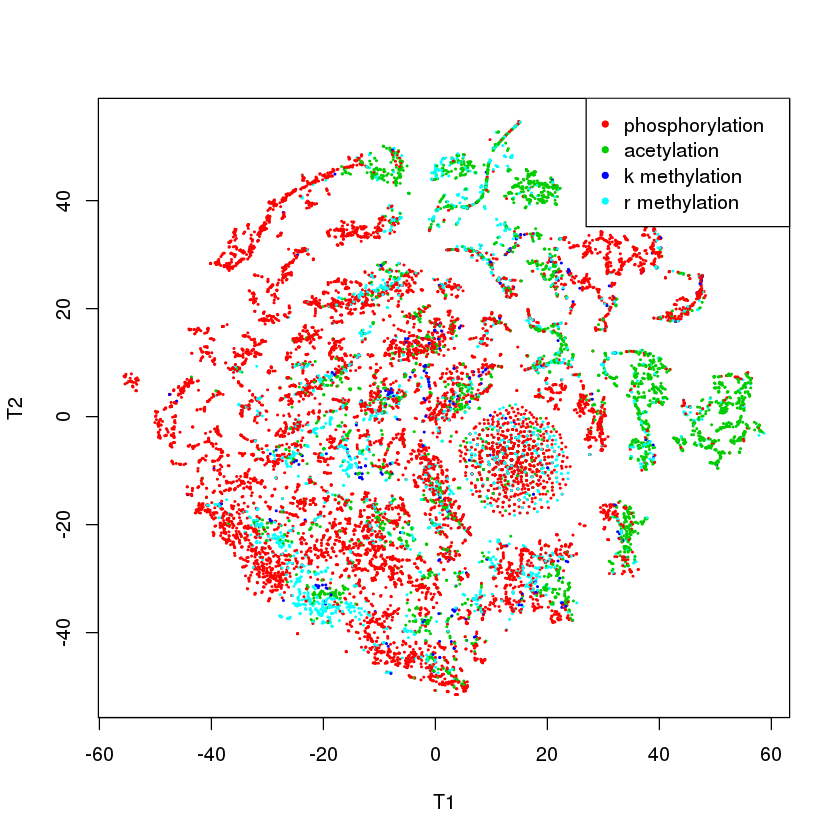

In [39]:
rr[gg] = 2
plot(ts$Y, pch=20, cex=0.3, xlab="T1", ylab="T2", col=rr)
legend("topright", legend=c("phosphorylation","acetylation","k methylation","r methylation"), col=2:5, pch=20)

In [45]:
phosphorylation_data = medpolish(ptm[g1, ], na.rm = T)$residuals
acetylation_data = medpolish(ptm[g2, ], na.rm = T)$residuals
kmeth_data = medpolish(ptm[g3, ], na.rm = T)$residuals
rmeth_data = medpolish(ptm[g4, ], na.rm = T)$residuals


1: 139279.8
2: 133022
Final: 132492
1: 47757.38
2: 45585.81
Final: 45434.07
1: 5774.063
2: 5464.992
Final: 5440.19
1: 36880.79
2: 34997.65
Final: 34853.54


In [47]:
normptm = do.call(rbind, list(phosphorylation_data, acetylation_data, kmeth_data, rmeth_data))
dim(normptm)

[1] 13798    77

In [ ]:
dat = normptm
dat[is.na(dat)] = 0
ts = Rtsne(dat, dims=2, perplexity=20, check_duplicates = F)

In [ ]:
g1 = grep(" p ", rownames(dat))
g2 = grep(" ack ", rownames(dat))
g3 = grep(" kme ", rownames(dat))
g4 = grep(" rme ", rownames(dat))

rr = rep(1, nrow(dat))
rr[g1] = 2
rr[g2] = 3
rr[g3] = 4
rr[g4] = 5

plot(ts$Y, pch=20, cex=0.3, xlab="T1", ylab="T2", col=rr)
legend("topright", legend=c("phosphorylation","acetylation","k methylation","r methylation"), col=2:5, pch=20)